In [1]:
pip install duckdb pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def connect_to_db():
    """Connect to the DuckDB database"""
    return duckdb.connect('maria_ap7.duckdb')

def show_table_info(con):
    """Display basic information about the tables"""
    print("Available tables:")
    print(con.execute("SHOW TABLES").fetchall())
    
    print("\ngeo_cal_vel schema:")
    print(con.execute("DESCRIBE geo_cal_vel").fetchdf())
    
    print("\npredictions schema:")
    print(con.execute("DESCRIBE predictions").fetchdf())

def get_basic_stats(con):
    """Get basic statistics about the data"""
    print("Table Statistics:")
    stats = con.execute("""
        SELECT 
            'geo_cal_vel' as table_name,
            COUNT(*) as row_count,
            MIN(dat) as min_date,
            MAX(dat) as max_date
        FROM geo_cal_vel
        UNION ALL
        SELECT 
            'predictions' as table_name,
            COUNT(*) as row_count,
            MIN(dat) as min_date,
            MAX(dat) as max_date
        FROM predictions
    """).fetchdf()
    print(stats)
    
    print("\nSample from geo_cal_vel:")
    print(con.execute("SELECT * FROM geo_cal_vel LIMIT 5").fetchdf())
    
    print("\nSample from predictions:")
    print(con.execute("SELECT * FROM predictions LIMIT 5").fetchdf())

def analyze_traffic_patterns(con):
    """Analyze traffic patterns by hour"""
    hourly_stats = con.execute("""
        SELECT 
            hor,
            AVG(mean_speed) as avg_speed,
            AVG(intTot) as avg_intensity,
            COUNT(*) as record_count
        FROM geo_cal_vel
        GROUP BY hor
        ORDER BY hor
    """).fetchdf()
    
    # Plot hourly patterns
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Speed plot
    ax1.plot(hourly_stats['hor'], hourly_stats['avg_speed'], marker='o')
    ax1.set_title('Average Speed by Hour')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Average Speed')
    ax1.grid(True)
    
    # Intensity plot
    ax2.plot(hourly_stats['hor'], hourly_stats['avg_intensity'], marker='o', color='orange')
    ax2.set_title('Average Traffic Intensity by Hour')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Average Intensity')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_predictions(con):
    """Analyze prediction accuracy"""
    comparison = con.execute("""
        SELECT 
            g.dat,
            g.mean_speed as actual_speed,
            p.mean_speed_pred as predicted_speed,
            g.intTot as actual_intensity,
            p.intTot_pred as predicted_intensity
        FROM geo_cal_vel g
        JOIN predictions p
        ON g.dat = p.dat
        AND g.via = p.via
        AND g.pk = p.pk
        AND g.sen = p.sen
        LIMIT 1000
    """).fetchdf()
    
    # Calculate prediction errors
    comparison['speed_error'] = comparison['predicted_speed'] - comparison['actual_speed']
    comparison['intensity_error'] = comparison['predicted_intensity'] - comparison['actual_intensity']
    
    # Plot actual vs predicted values
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Speed comparison
    ax1.scatter(comparison['actual_speed'], comparison['predicted_speed'], alpha=0.5)
    ax1.plot([0, comparison['actual_speed'].max()], [0, comparison['actual_speed'].max()], 'r--')
    ax1.set_title('Actual vs Predicted Speed')
    ax1.set_xlabel('Actual Speed')
    ax1.set_ylabel('Predicted Speed')
    
    # Intensity comparison
    ax2.scatter(comparison['actual_intensity'], comparison['predicted_intensity'], alpha=0.5)
    ax2.plot([0, comparison['actual_intensity'].max()], [0, comparison['actual_intensity'].max()], 'r--')
    ax2.set_title('Actual vs Predicted Intensity')
    ax2.set_xlabel('Actual Intensity')
    ax2.set_ylabel('Predicted Intensity')
    
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    print("\nPrediction Error Statistics:")
    print("Speed Error:")
    print(comparison['speed_error'].describe())
    print("\nIntensity Error:")
    print(comparison['intensity_error'].describe())

def analyze_geographic_patterns(con):
    """Analyze traffic patterns by location"""
    location_stats = con.execute("""
        SELECT 
            via,
            COUNT(DISTINCT pk) as num_points,
            AVG(mean_speed) as avg_speed,
            AVG(intTot) as avg_intensity
        FROM geo_cal_vel
        GROUP BY via
        ORDER BY num_points DESC
        LIMIT 10
    """).fetchdf()
    
    print("Top 10 locations by number of measurement points:")
    print(location_stats)
    
    # Plot location statistics
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Speed by location
    ax1.bar(location_stats['via'], location_stats['avg_speed'])
    ax1.set_title('Average Speed by Location')
    ax1.set_xlabel('Location (via)')
    ax1.set_ylabel('Average Speed')
    plt.xticks(rotation=45)
    
    # Intensity by location
    ax2.bar(location_stats['via'], location_stats['avg_intensity'])
    ax2.set_title('Average Traffic Intensity by Location')
    ax2.set_xlabel('Location (via)')
    ax2.set_ylabel('Average Intensity')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def check_data_quality(con):
    """Check for data quality issues and missing values"""
    print("Missing values in geo_cal_vel:")
    missing_geo = con.execute("""
        SELECT column_name, COUNT(*) as null_count
        FROM (
            SELECT * FROM geo_cal_vel
        ) t
        UNPIVOT (value FOR column_name IN (*))
        WHERE value IS NULL
        GROUP BY column_name
        ORDER BY null_count DESC
    """).fetchdf()
    print(missing_geo)
    
    print("\nMissing values in predictions:")
    missing_pred = con.execute("""
        SELECT column_name, COUNT(*) as null_count
        FROM (
            SELECT * FROM predictions
        ) t
        UNPIVOT (value FOR column_name IN (*))
        WHERE value IS NULL
        GROUP BY column_name
        ORDER BY null_count DESC
    """).fetchdf()
    print(missing_pred)

Available tables:
[('geo_cal_vel',), ('predictions',)]

geo_cal_vel schema:
             column_name column_type null   key default extra
0                    dat   TIMESTAMP  YES  None    None  None
1                    Any      BIGINT  YES  None    None  None
2                    mes      BIGINT  YES  None    None  None
3                    dia      BIGINT  YES  None    None  None
4                 diaSem      BIGINT  YES  None    None  None
5                    hor      BIGINT  YES  None    None  None
6                    via     VARCHAR  YES  None    None  None
7                     pk      BIGINT  YES  None    None  None
8                    sen     VARCHAR  YES  None    None  None
9             mean_speed      BIGINT  YES  None    None  None
10         std_dev_speed      DOUBLE  YES  None    None  None
11         percentile_10      BIGINT  YES  None    None  None
12         percentile_85      BIGINT  YES  None    None  None
13                intTot      BIGINT  YES  None    None 

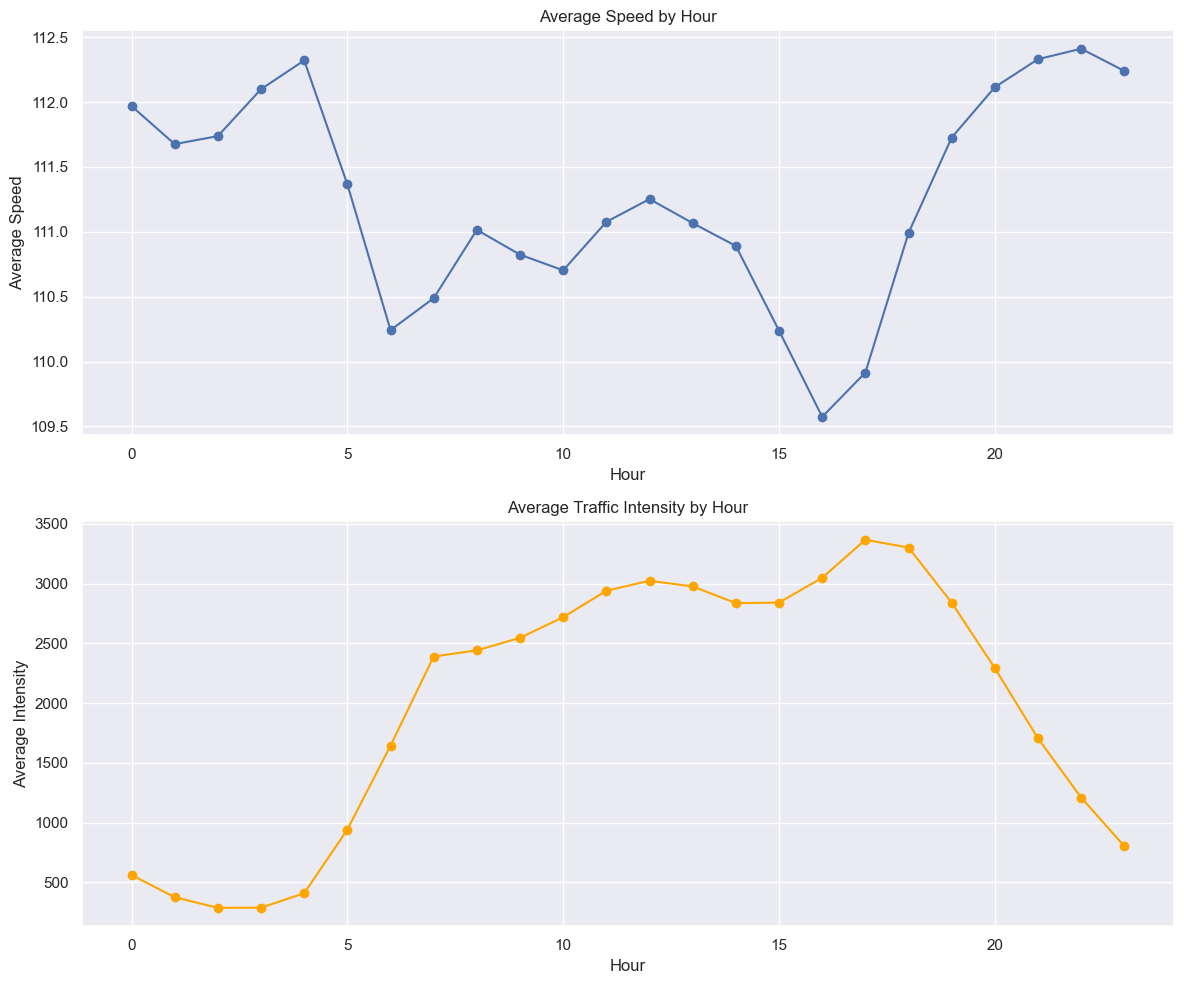


Database connection closed.


ConversionException: Conversion Error: Could not convert string 'AP-7' to INT64 when casting from source column via

LINE 11:         AND g.via = p.via
                     ^

In [3]:
# Set up plotting style
%matplotlib inline
plt.style.use('default')  # Use default style instead of seaborn
sns.set_theme()  # This will set seaborn's default theme

# Connect to database
con = connect_to_db()

try:
    # Show table information
    show_table_info(con)
    
    # Get basic statistics
    get_basic_stats(con)
    
    # Analyze traffic patterns
    analyze_traffic_patterns(con)
    
    # Analyze predictions
    analyze_predictions(con)
    
    # Analyze geographic patterns
    analyze_geographic_patterns(con)
    
    # Check data quality
    check_data_quality(con)
    
finally:
    # Close the connection
    con.close()
    print("\nDatabase connection closed.")
